# Study Log
- **220411 mon**
    - 학습이 안되는 문제

- **220413 wed**
    - `(2014) GoogLeNet.ipynb` 2개의 포맷에 맞춰서 모델 직접 학습해서 train, validation, test 해보자
        - 모델 여러 버전으로 시도해 볼 것
        - `Given input size: (256x2x2). Calculated output size: (256x0x0). Output size is too small`라는 에러 출력
        - 같은 데이터를 사용해도 모델 구조가 다르다는 점을 염두에 두자
        - 모델 구조에 대한 학습이 선행 되어야 할 듯
    - pretrained model 이용하는 코드 : [AlexNet in PyTorch CIFAR10 Clas(83% Test Accuracy)](https://www.kaggle.com/code/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy)

- **220414 thur**
    - colab에서 gpu쓰면서 돌리려면 모델, 데이터 모두에게 .to(device)해서 gpu에 할당해 줘야 함
    - for data, target in data_loader: \n data.to(device) -> 이런 식 말고
    - dataloader에 바로 cpu 할당하는 것도 가능?
    - 참고한 코드
        - [[CV] AlexNet(2012) 논문을 code로 구현 해보자 (Keras, PyTorch)](https://daeun-computer-uneasy.tistory.com/35?category=1005585)
        - `def forward` 부분 들여쓰기 안해서 에러남 -> 수정 완료
        - [[논문] AlexNet](https://123okk2.tistory.com/171)
    - FC layers dropout의 `inplace = True` -> `inplace = False (or parameter 입력 안 함)`로 수정
- **220415 fri**
    - 최종본 정리

# Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

# 결과 확인을 용이하게 하기 위한 코드
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

Files already downloaded and verified
torch.Size([32, 3, 227, 227])
torch.Size([32])


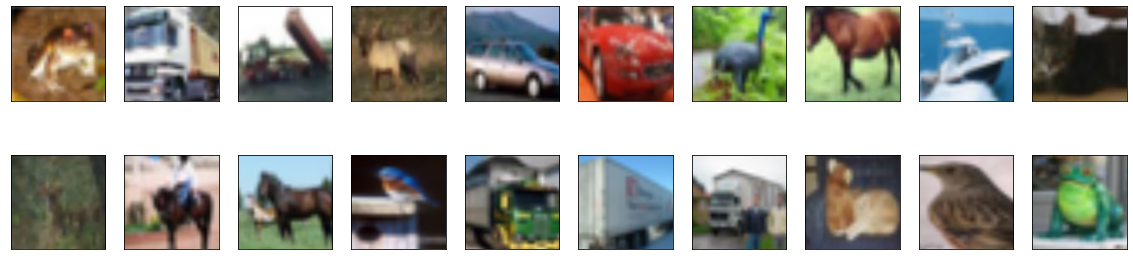

In [3]:
'''
⭐️ transforms의 parameter test
'''
## ToTensor(), Resize(256), RandomCrop(227) ...

# function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image

batch_size = 32

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize(256),
                                       transforms.RandomCrop(227),
                                       transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

train_data = datasets.CIFAR10('./data', train = True, download = True, transform = train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# fig = plt.figure(figsize=(30, 30))
fig = plt.figure(figsize=(20, 5))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
# Define transform options
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(227),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])
                                      
test_transform = transforms.Compose([transforms.Resize(227),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

# Data load
train_data = datasets.CIFAR10('./data', download = True, train = True, transform = train_transform) # len : 50000
test_data = datasets.CIFAR10('./data', download = True, train = False, transform = test_transform) # len : 10000

# Train, valid split
valid_size = 0.15
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(valid_size * len(train_data)))

train_idx, valid_idx = indices[split:], indices[:split]
print(len(train_idx))
print(len(valid_idx))

# Define samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders (Combine dataset and sampler)
batch_size = 256
train_dl = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
val_dl = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
test_dl = torch.utils.data.DataLoader(test_data, batch_size = batch_size)